In [4]:
import numpy as np
import pandas as pd
import os

### Abstract and title cleaning

In [3]:
df_final = pd.read_csv("final_dataset_cleaned.csv")

In [16]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

abstract_process_lst = []
for i in df_final["abstract"]:
    if i is np.nan:
        abstract_process_lst.append("")
        continue
    token_words = word_tokenize(i)
    wordnet_lematizer = WordNetLemmatizer()
    words_lematizer = [wordnet_lematizer.lemmatize(token_word) for token_word in token_words]
    cleaned_words = [word for word in words_lematizer if word not in stopwords.words('english')]
    characters = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','-','...','^','{','}']
    words_list = [word for word in cleaned_words if word not in characters]
    words_lists = [x.lower() for x in words_list ]
    abstract_process_lst.append(" ".join(words_lists))
df_final["processed_abstract"] = abstract_process_lst

In [11]:
df_final = pd.read_csv("final_dataset_cleaned.csv")

In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

abstract_process_lst = []
for i in df_final["title"]:
    if i is np.nan:
        abstract_process_lst.append("")
        continue
    token_words = word_tokenize(i)
    wordnet_lematizer = WordNetLemmatizer()
    words_lematizer = [wordnet_lematizer.lemmatize(token_word) for token_word in token_words]
    cleaned_words = [word for word in words_lematizer if word not in stopwords.words('english')]
    characters = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','-','...','^','{','}']
    words_list = [word for word in words_lematizer if word not in characters]
    words_lists = [x.lower() for x in words_list ]
    abstract_process_lst.append(" ".join(words_lists))
df_final["processed_title"] = abstract_process_lst

In [4]:
df_final.set_index("title").to_csv("final_dataset_cleaned.csv")

### TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(df_final["processed_abstract"].fillna("NAN"))

### Dimension reduction

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=42)
%time X_embedded_pca= pca.fit_transform(X.toarray())
X_embedded_pca.shape

Wall time: 2min 10s


(92458, 20)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne.fit_transform(X_embedded_pca)

array([[ -2.1586483, -34.2416   ],
       [-24.494745 ,  -7.593376 ],
       [-18.691336 , -35.13134  ],
       ...,
       [ 28.309254 ,  21.242905 ],
       [ -4.5281935,   5.6231923],
       [  2.5391748,  16.651068 ]], dtype=float32)

In [15]:
df_final['x_tsne'] = tsne.embedding_[:,0] 
df_final['y_tsne'] = tsne.embedding_[:,1]

C:\Users\williamsyy\.conda\envs\pytorch\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


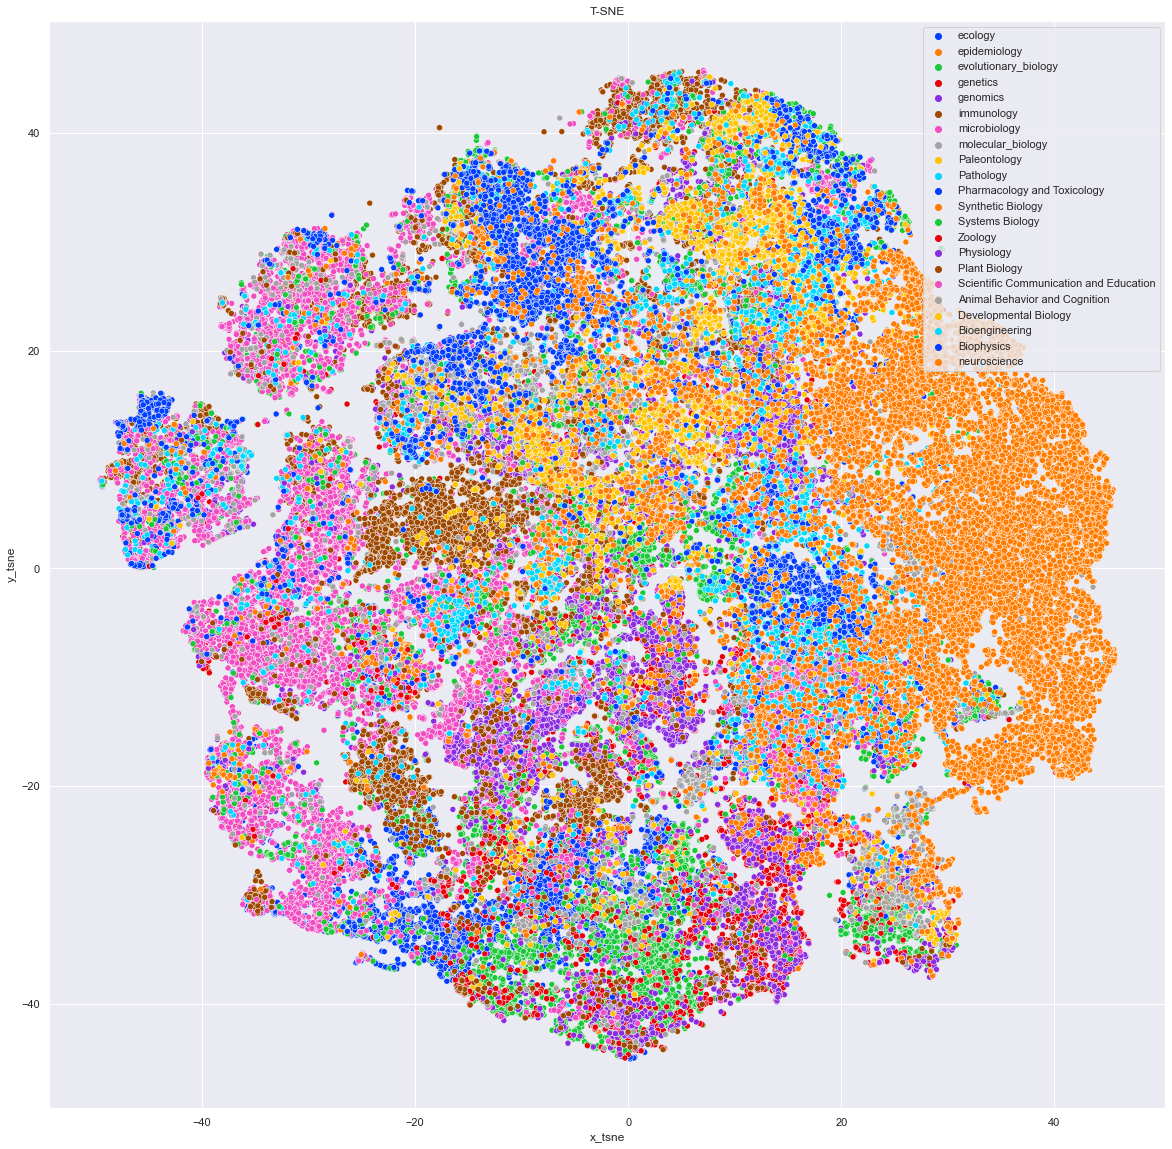

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# sns settings
sns.set(rc={'figure.figsize':(20,20)})

# plot
sns.scatterplot(df_final["x_tsne"], df_final["y_tsne"], hue=list(df_final["subjet_area"]), legend='full', palette="bright")
plt.title('T-SNE')
plt.savefig("biorxiv_TSNE_new.png", dpi=400)
plt.show()

### Clustering procedure

In [52]:
from sklearn.cluster import DBSCAN
X = df_final[["x_tsne","y_tsne"]]
clustering = DBSCAN(eps = 1.5,min_samples=100).fit(X)

C:\Users\williamsyy\.conda\envs\pytorch\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


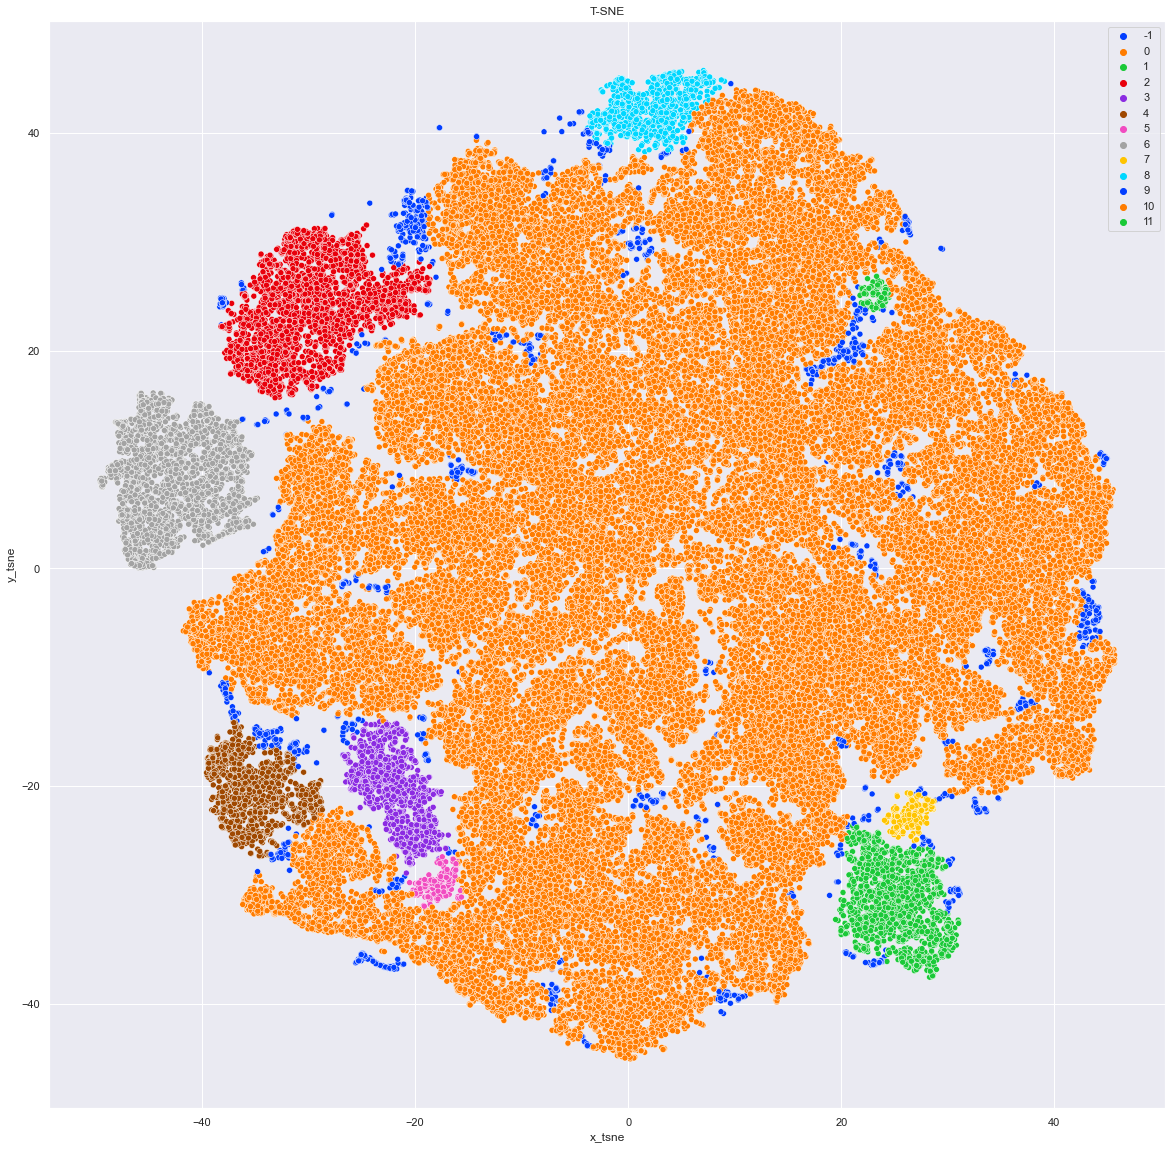

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
# sns settings
sns.set(rc={'figure.figsize':(20,20)})

# plot
sns.scatterplot(df_final["x_tsne"], df_final["y_tsne"], hue=clustering.labels_, legend='full', palette="bright")
plt.title('T-SNE')
# plt.savefig("biorxiv_TSNE_new.png", dpi=400)
plt.show()

### Cluster key words counts

In [167]:
df_cluster = pd.read_csv("final_dataset_cleaned_cluster.csv")

In [189]:
import collections
a = pd.DataFrame(collections.Counter(" ".join(list(df_cluster[df_cluster["cluster"]==1]["processed_title"])).split(" ")).items()).sort_values(1,ascending=False)

In [232]:
collect_lst = []
for num in range(-1,12):
    a = pd.DataFrame(collections.Counter(" ".join(list(df_cluster[df_cluster["cluster"]==num]["processed_title"])).split(" ")).items()).sort_values(1,ascending=False)
    a[1] = round(a[1]/len(df_cluster[df_cluster["cluster"]==num]),4)
    count = 0
    for i in np.array(a):
        if count >= 5:
            break
        if i[0] not in stopwords.words('english'):
            print(list(i)+[num])
            collect_lst.append(list(i)+[num])
            count+=1

['cell', 0.0928, -1]
['human', 0.0757, -1]
['genetic', 0.0604, -1]
['network', 0.0568, -1]
['model', 0.0562, -1]
['cell', 0.0733, 0]
['gene', 0.064, 0]
['human', 0.0543, 0]
['analysis', 0.0511, 0]
['model', 0.0447, 0]
['sex', 0.2094, 1]
['male', 0.1572, 1]
['female', 0.1267, 1]
['sexual', 0.09, 1]
['chromosome', 0.0794, 1]
['virus', 0.4259, 2]
['infection', 0.1553, 2]
['viral', 0.1325, 2]
['cell', 0.1122, 2]
['influenza', 0.1113, 2]
['plant', 0.3201, 3]
['root', 0.136, 3]
['growth', 0.0739, 3]
['specie', 0.0649, 3]
['leaf', 0.0649, 3]
['gut', 0.3843, 4]
['microbiome', 0.269, 4]
['microbiota', 0.2452, 4]
['microbial', 0.1259, 4]
['human', 0.1068, 4]
['dna', 0.4928, 5]
['metabarcoding', 0.2967, 5]
['environmental', 0.2775, 5]
['using', 0.177, 5]
['edna', 0.1722, 5]
['sars-cov-2', 0.753, 6]
['covid-19', 0.1574, 6]
['spike', 0.1411, 6]
['infection', 0.1235, 6]
['protein', 0.1194, 6]
['social', 0.4955, 7]
['group', 0.1429, 7]
['individual', 0.0893, 7]
['learning', 0.0804, 7]
['behaviour', 0

In [233]:
df_collect = pd.DataFrame(collect_lst)
df_collect.columns = ["key words","frequency","cluster"]

In [234]:
df_collect.set_index("key words").to_csv("cluster key words_new_5_1.csv")